In [1]:
# Create the Spark Session
from pyspark.sql import SparkSession

spark = (
    SparkSession 
    .builder 
    .appName("Streaming from Kafka") 
    .config("spark.streaming.stopGracefullyOnShutdown", True) 
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0')
    .config("spark.sql.shuffle.partitions", 4)
    .master("local[*]") 
    .getOrCreate()
)

spark

In [2]:
# Create the kafka_df to read from kafka

kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "ed-kafka:29092")
    .option("subscribe", "climate_data.temperature_data")
    .option("startingOffsets", "earliest")
    .load()
)


In [3]:
# View schema for raw kafka_df
kafka_df.printSchema()
# kafka_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
# Parse value from binay to string into kafka_json_df
from pyspark.sql.functions import expr
from pyspark.sql.functions import regexp_replace, col, from_json
from pyspark.sql.types import StringType

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
# kafka_json_df.show(truncate=False)


In [5]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

schema = StructType([
    StructField("_id", StructType([
        StructField("$oid", StringType(), True)
    ]), True),
    StructField("operationType", StringType(), True),
    StructField("clusterTime", StructType([
        StructField("$timestamp", StructType([
            StructField("t", DoubleType(), True),
            StructField("i", DoubleType(), True)
        ]), True)
    ]), True),
    StructField("wallTime", StructType([
        StructField("$date", DoubleType(), True)
    ]), True),
    StructField("fullDocument", StructType([
        StructField("_id", StructType([
            StructField("$oid", StringType(), True)
        ]), True),
        StructField("lat", StringType(), True),
        StructField("lon", StringType(), True),
        StructField("z", StringType(), True),
        StructField("time", StringType(), True),
        StructField("anom", StringType(), True)
    ]), True),
    StructField("ns", StructType([
        StructField("db", StringType(), True),
        StructField("coll", StringType(), True)
    ]), True),
    StructField("documentKey", StructType([
        StructField("_id", StructType([
            StructField("$oid", StringType(), True)
        ]), True)
    ]), True)
])


In [6]:
from pyspark.sql.functions import regexp_replace, col

# Remove unwanted characters using a stricter regular expression
cleaned_kafka_df = kafka_json_df.withColumn(
    "clean_value",
    regexp_replace(col("value"), r"[^ -~]", "",)  # Matches printable ASCII characters only
)

# Show the cleaned data
# cleaned_kafka_df.select("clean_value").show(truncate=False)


In [7]:
from pyspark.sql.functions import from_json,col
from pyspark.sql.functions import regexp_replace, col

streaming_df = cleaned_kafka_df.withColumn(
    "values_json", 
    from_json(col("clean_value"), schema)
).selectExpr("values_json.*")

# Show the parsed DataFrame
# streaming_df.show(truncate=False)

In [8]:
streaming_df.printSchema()
# streaming_df.show(truncate=False)

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- operationType: string (nullable = true)
 |-- clusterTime: struct (nullable = true)
 |    |-- $timestamp: struct (nullable = true)
 |    |    |-- t: double (nullable = true)
 |    |    |-- i: double (nullable = true)
 |-- wallTime: struct (nullable = true)
 |    |-- $date: double (nullable = true)
 |-- fullDocument: struct (nullable = true)
 |    |-- _id: struct (nullable = true)
 |    |    |-- $oid: string (nullable = true)
 |    |-- lat: string (nullable = true)
 |    |-- lon: string (nullable = true)
 |    |-- z: string (nullable = true)
 |    |-- time: string (nullable = true)
 |    |-- anom: string (nullable = true)
 |-- ns: struct (nullable = true)
 |    |-- db: string (nullable = true)
 |    |-- coll: string (nullable = true)
 |-- documentKey: struct (nullable = true)
 |    |-- _id: struct (nullable = true)
 |    |    |-- $oid: string (nullable = true)



In [9]:
from pyspark.sql.functions import explode

exploded_df = streaming_df.selectExpr("fullDocument")

In [10]:
exploded_df.printSchema()
# exploded_df.show(truncate=False)

root
 |-- fullDocument: struct (nullable = true)
 |    |-- _id: struct (nullable = true)
 |    |    |-- $oid: string (nullable = true)
 |    |-- lat: string (nullable = true)
 |    |-- lon: string (nullable = true)
 |    |-- z: string (nullable = true)
 |    |-- time: string (nullable = true)
 |    |-- anom: string (nullable = true)



In [11]:
from pyspark.sql.functions import col

# Flatten the `fullDocument` struct
flattened_fullDocument_df = streaming_df.select(
    col("fullDocument._id.$oid").alias("document_id"),
    col("fullDocument.lat").alias("latitude"),
    col("fullDocument.lon").alias("longitude"),
    col("fullDocument.z").alias("altitude"),
    col("fullDocument.time").alias("timestamp"),
    col("fullDocument.anom").alias("anomaly")
)

In [12]:
# Check the schema of the flattened_df, place a sample json file and change readStream to read 
flattened_fullDocument_df.printSchema()
flattened_fullDocument_df.show(10, truncate=False)


root
 |-- document_id: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- anomaly: string (nullable = true)

+------------------------+--------+---------+--------+----------+-------+
|document_id             |latitude|longitude|altitude|timestamp |anomaly|
+------------------------+--------+---------+--------+----------+-------+
|67567b300dffb168d8a99d32|null    |null     |null    |null      |null   |
|67568f560dffb168d8a99d33|2193    |null     |null    |null      |null   |
|null                    |null    |null     |null    |null      |null   |
|67568fcea43772890d6921b2|-87.5   |2.5      |0.0     |2020-12-01|"NaN"  |
|67568fcea43772890d6921b3|-87.5   |7.5      |0.0     |2020-12-01|"NaN"  |
|67568fcea43772890d6921b4|-87.5   |12.5     |0.0     |2020-12-01|"NaN"  |
|67568fcea43772890d6921b5|-87.5   |17.5     |0.0     |2020-12-01|"NaN"  |
|67568fcea

### Generate Map

In [13]:
!pip install numpy

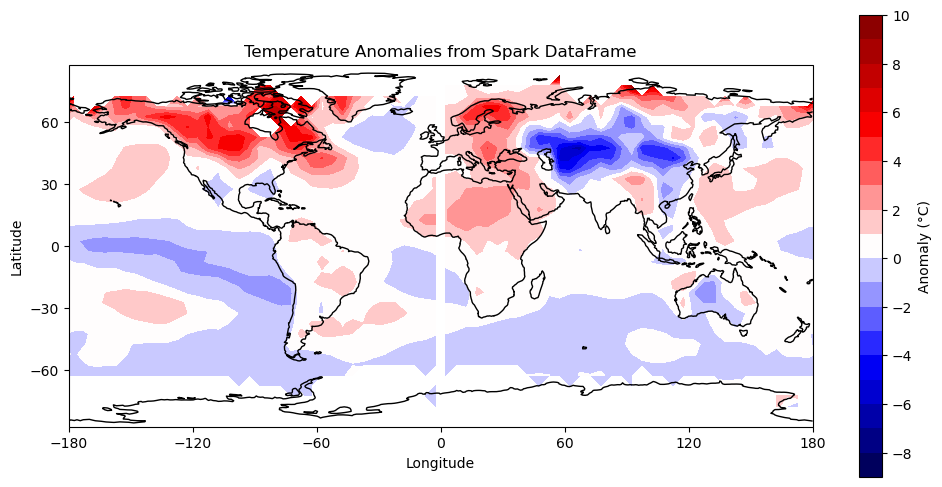

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from pyspark.sql import functions as F

# Step 1: Filter valid data from Spark DataFrame
filtered_df = (
    flattened_fullDocument_df.filter(
        (F.col("latitude").isNotNull()) &
        (F.col("longitude").isNotNull()) &
        (F.col("anomaly").isNotNull()) &
        (F.col("latitude") != "null") &
        (F.col("longitude") != "null") &
        (F.col("anomaly") != "null")
    )
    .withColumn("latitude", F.col("latitude").cast("float"))
    .withColumn("longitude", F.col("longitude").cast("float"))
    .withColumn("anomaly", F.col("anomaly").cast("float"))
)

# Step 2: Convert Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.select("latitude", "longitude", "anomaly").toPandas()

# Step 3: Extract values for plotting
lats = pandas_df['latitude'].values
lons = pandas_df['longitude'].values
anoms = pandas_df['anomaly'].values

# Step 4: Create a grid and populate anomalies
unique_lats = np.unique(lats)
unique_lons = np.unique(lons)
lon_grid, lat_grid = np.meshgrid(unique_lons, unique_lats)

# Initialize anomaly grid with NaNs
anom_grid = np.full(lon_grid.shape, np.nan)

# Map anomalies to the grid
for lat, lon, anom in zip(lats, lons, anoms):
    lat_idx = np.where(unique_lats == lat)[0][0]
    lon_idx = np.where(unique_lons == lon)[0][0]
    anom_grid[lat_idx, lon_idx] = anom

# Step 5: Plot the data using Cartopy
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.set_xticks(range(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Contour plot for anomalies
c = ax.contourf(lon_grid, lat_grid, anom_grid, levels=20, cmap="seismic", transform=ccrs.PlateCarree())

# Add a color bar
plt.colorbar(c, label='Anomaly (°C)')

plt.title('Temperature Anomalies from Spark DataFrame')
plt.show()


In [ ]:
plt.show()

In [ ]:
# (flattened_fullDocument_df
#  .writeStream
#  .format("console")
#  .outputMode("append")
#  .option("checkpointLocation", "checkpoint_dir_kafka")
#  .option("failOnDataLose", "false")
#  .start()
#  .awaitTermination())
